<a href="https://colab.research.google.com/github/ibacaraujo/fast.ai-project/blob/master/research_lesson01.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Research and development predicated on Lesson 01

In [4]:
import fastai
fastai.__version__

'1.0.52'

In [5]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)
root_dir = "/content/gdrive/My Drive/"
base_dir = root_dir + "fastai_research"

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [0]:
from fastai.vision import *
from fastai.metrics import error_rate

In [0]:
bs = 64
# bs = 16 # uncomment this line if you run out of memory even after restarting

## Looking at the data

The first thing we do when we approach a problem is to take a look at the data. We *always* need to understand very well what the problem is and what the data looks like before we can figure out how to solve it. Taking a look at the data means understanding how the data directories are structured, what the labels are and what some sample images look like.

In [0]:
path = base_dir + '/dataset/weather/'

In [10]:
fnames = get_image_files(path + 'train/sunny/')
fnames[:5]

[PosixPath('/content/gdrive/My Drive/fastai_research/dataset/weather/train/sunny/65-20160324_171450-001.jpg'),
 PosixPath('/content/gdrive/My Drive/fastai_research/dataset/weather/train/sunny/82-20160325_080005-001.jpg'),
 PosixPath('/content/gdrive/My Drive/fastai_research/dataset/weather/train/sunny/20535-20160319_165435-001.jpg'),
 PosixPath('/content/gdrive/My Drive/fastai_research/dataset/weather/train/sunny/146-20160324_105346-250.jpg'),
 PosixPath('/content/gdrive/My Drive/fastai_research/dataset/weather/train/sunny/20332-20160327_114438-250.jpg')]

In [0]:
data = ImageDataBunch.from_folder(path, ds_tfms=get_transforms(), size=224,
                                  bs=bs).normalize(imagenet_stats)

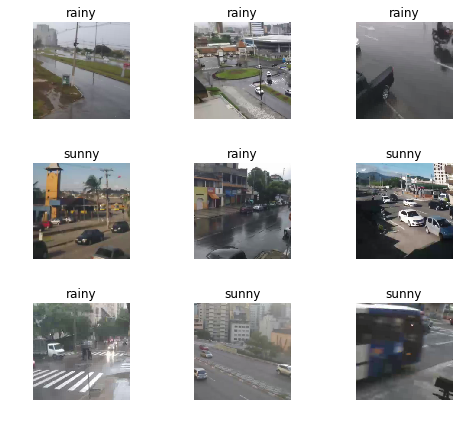

In [12]:
data.show_batch(rows=3, figsize=(7,6))

In [13]:
print(data.classes)

['rainy', 'sunny']


In [14]:
len(data.classes)

2

In [15]:
data.c

2

## Training with ResNet-34

We are building a model which will take images as input and will output the predicted probability for each of the categories (in this case, it will have 2 outputs).

We will train for 4 epochs (4 cycles through all our data).

In [16]:
learn = cnn_learner(data, models.resnet34, metrics=error_rate)

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/checkpoints/resnet34-333f7ec4.pth
100%|██████████| 87306240/87306240 [00:03<00:00, 23510529.57it/s]


In [17]:
learn.model

Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (rel

In [18]:
learn.fit_one_cycle(4)

epoch,train_loss,valid_loss,error_rate,time
0,0.556934,0.226998,0.096842,09:13
1,0.366656,0.140510,0.058947,00:45
2,0.268108,0.116194,0.050526,00:43
3,0.212435,0.112336,0.042105,00:41


In [0]:
learn.save('stage-1')

## Results

Let's see what results we have got. We will try to see if what the model predicted was reasonable or not. Furthermore, we will plot the confusion matrix.

In [20]:
interp = ClassificationInterpretation.from_learner(learn)
losses, idxs = interp.top_losses()
len(data.valid_ds) == len(losses) == len(idxs)

True

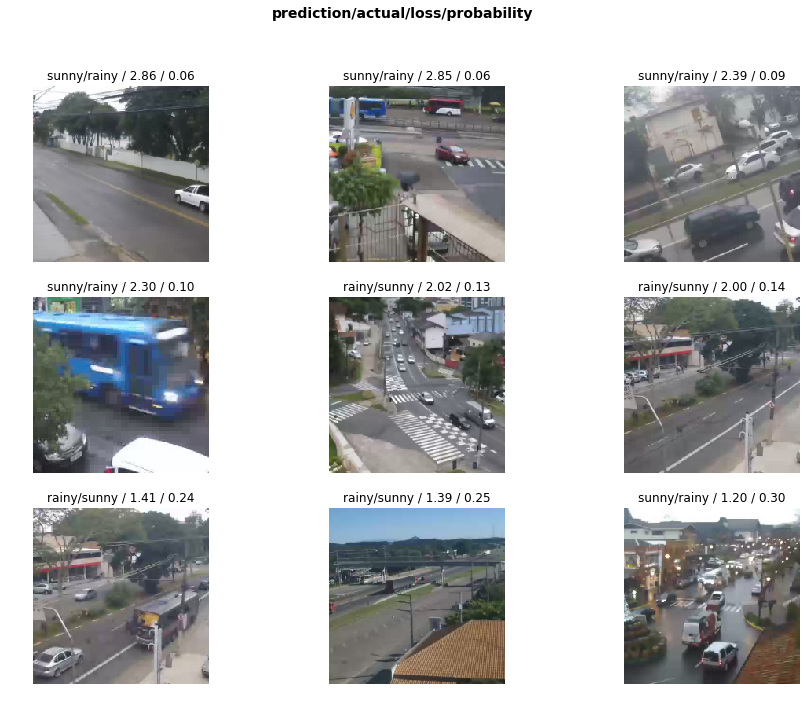

In [23]:
interp.plot_top_losses(9, figsize=(15,11), heatmap=False)

In [0]:
#doc(interp.plot_top_losses)

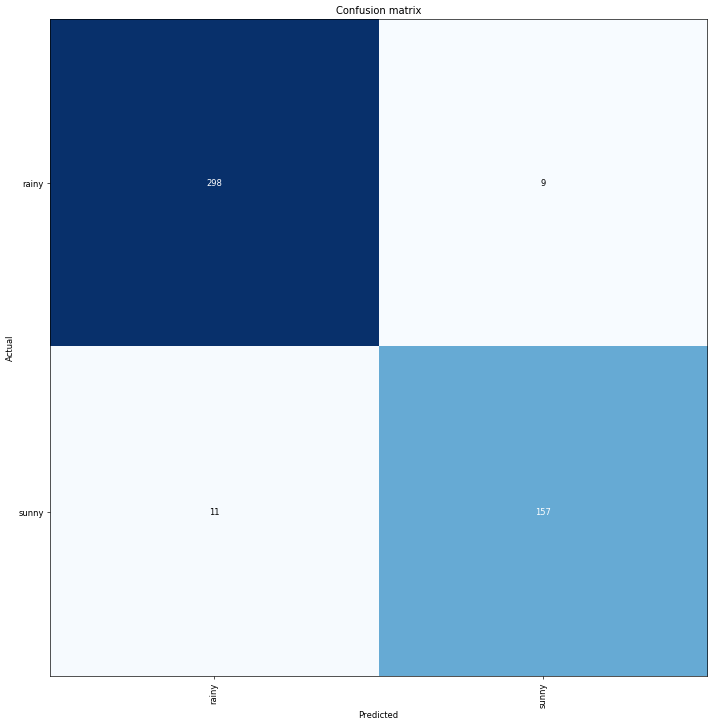

In [26]:
interp.plot_confusion_matrix(figsize=(12,12), dpi=60)

In [27]:
interp.most_confused(min_val=2)

[('sunny', 'rainy', 11), ('rainy', 'sunny', 9)]

## Unfreezing, fine-tuning, and learning rates

Since our model is working as we expect it to, we will *unfreeze* our model and train some more.

In [0]:
learn.unfreeze()

In [29]:
learn.fit_one_cycle(1)

epoch,train_loss,valid_loss,error_rate,time
0,0.187715,0.060291,0.025263,00:43


In [0]:
learn.save('stage-2')

In [0]:
# learn.load('stage-1');

In [30]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


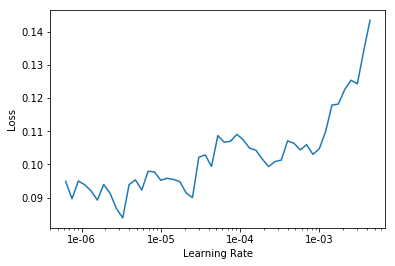

In [32]:
learn.recorder.plot()

Ok, the model has already started to learn the proper parameters in the moment that *lr_find* was used. So, that is the reason why the plot is ascending in such a way shown above.

Comparing with lesson 1 example, the error rate is lower for the dataset being used. So, I can conclude this is a pretty accurate model! Let me plot the confusion matrix after this model has been unfreezed and trained again.

In [0]:
interp = ClassificationInterpretation.from_learner(learn)

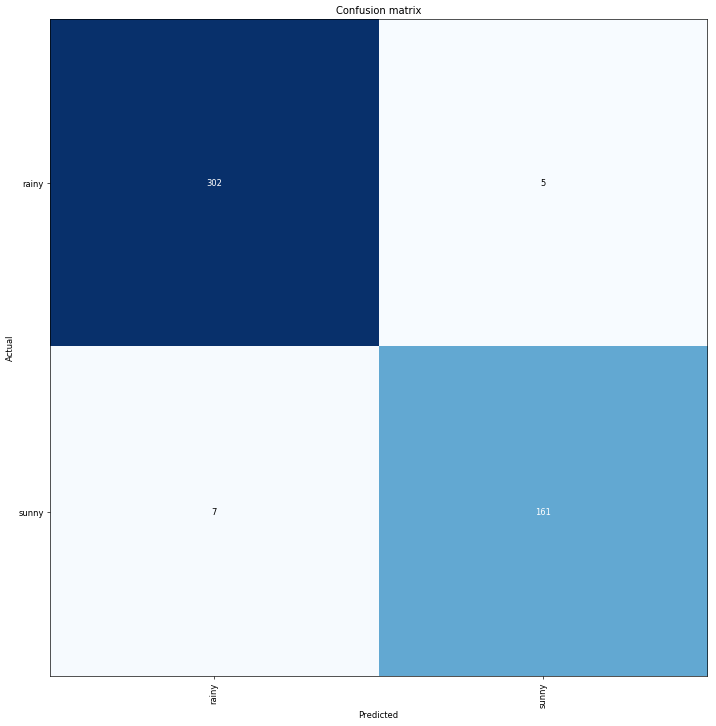

In [37]:
interp.plot_confusion_matrix(figsize=(12,12), dpi=60)

So, as we can, the unfreezed model is better. It is more accurate than the previous freezed version. Great!

## Training with ResNet-50

We will use ResNet-50 as our backbone now. ResNet-34 is a 34 layer residual network while ResNet-50 has 50 layers. Basically, ResNet-50 usually performs better because it is a deeper network with more parameters. Let's see if we can achieve a higher performance here.

To help it along, let's us use larger images too, since that way the network can see more detail. We reduce the batch size a bit since otherwise this larger network will require more GPU memory.

In [0]:
data = ImageDataBunch.from_folder(path, ds_tfms=get_transforms(), size=299,
                                 bs=bs//2).normalize(imagenet_stats)

In [39]:
learn = cnn_learner(data, models.resnet50, metrics=error_rate)

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/checkpoints/resnet50-19c8e357.pth
100%|██████████| 102502400/102502400 [00:00<00:00, 109403975.90it/s]


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


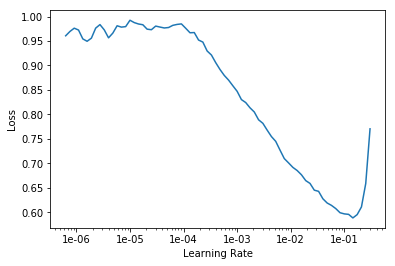

In [40]:
learn.lr_find()
learn.recorder.plot()

In [41]:
learn.fit_one_cycle(8)

epoch,train_loss,valid_loss,error_rate,time
0,0.378652,0.144019,0.058947,01:10
1,0.269412,0.107069,0.044211,01:07
2,0.171634,0.054518,0.021053,01:08
3,0.137164,0.070492,0.027368,01:08
4,0.116395,0.040906,0.014737,01:09
5,0.076819,0.036679,0.012632,01:07
6,0.064303,0.036653,0.010526,01:08
7,0.060100,0.036301,0.010526,01:08


In [0]:
learn.save('stage-1-50')

Boy, it is astonishing that it's possible to recognize and distiguish rainy from sunny images in this weather dataset. It is a great insight. Let's see if full fine-tuning helps.

In [44]:
learn.unfreeze()
learn.fit_one_cycle(3, max_lr=slice(1e-4,1e-2))

epoch,train_loss,valid_loss,error_rate,time
0,0.204244,0.612487,0.174737,01:11
1,0.171602,0.095767,0.035789,01:12
2,0.092241,0.036607,0.012632,01:12


If it doesn't, as it is the case, we can always go back to the previous model.

In [0]:
learn.load('stage-1-50');

In [0]:
interp = ClassificationInterpretation.from_learner(learn)

In [51]:
interp.most_confused(min_val=2)

[('sunny', 'rainy', 4)]

In [52]:
interp.most_confused(min_val=1)

[('sunny', 'rainy', 4), ('rainy', 'sunny', 1)]

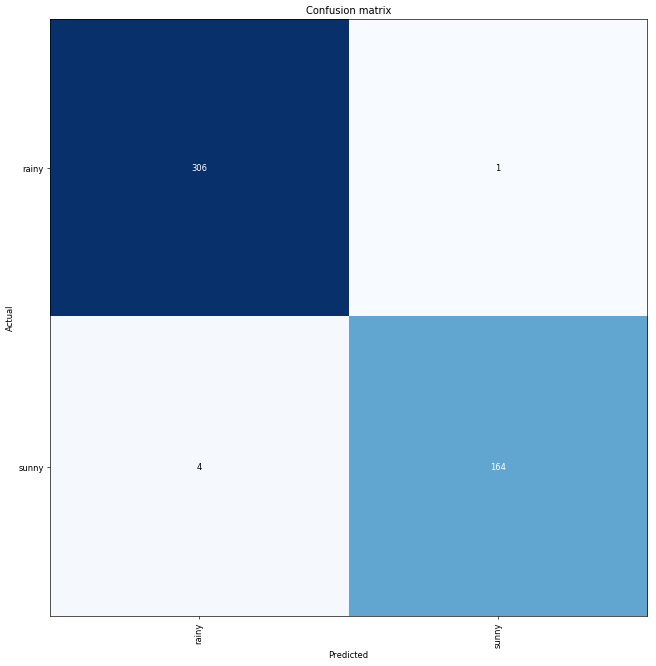

In [49]:
interp.plot_confusion_matrix(figsize=(15,11), dpi=60)

Impressive results. The model only confused 1 rainy image as sunny. For the opposite case, the model confused just 4 sunny images as rainy. Great, boy!